In [153]:
import matplotlib as plt
plt.rcParams['figure.figsize'] = [6, 8]
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("""
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
<style>.container { width:100% !important; height:100% !important;}</style>
<style>
table {float:left}
</style>

"""))

import pandas as pd
import numpy as np
from cassandra.cluster import Cluster

file_path="/home/seanc/delete-me/levski-no-messages/levski-consumer-log-2.log"
times = pd.read_csv(file_path, sep="\s+", names=["timestamp","group","topic","dunno","offset","log","lag","consumer"], index_col=0, parse_dates=True)
times['speed'] = times['offset'].diff() / times.index.to_series().diff().dt.total_seconds()

# Introduction

Testing was completed in perf-01, on load 8.1.0-alpha-12, levski 2.0.4

Messages were created using the trumpet tool, as per the following command:
```
docker run -it --rm ship.cenx.com:5000/trumpet:0.3.2-SNAPSHOT -z "ui01-perf01.cenx.localnet:2181" --tapi-url="ui01-perf01.cenx.localnet:8080" --num-ids 1000 -s "2018-03-01T00:03:00" -e "2018-03-01T00:13:00" -i 1 --entity-type PseudoVM --target kafka --topic nms2
```
which translates to 2.4 million entities.

```clojure
{:total-messages 2400000
 :metric-names ["ICMP-availability" "SNMP-availability" "laLoadInt" "ssCpuRawUser"], 
 :start 1519862580000, 
 :stop 1519863180000, 
 :interval 1000, 
 :ids [< 1 thousand>]
```

## Kafka log processing
The `kafka-consumer-offset-checker.sh` tool was used to poll the offset roughly every second, as follows:
```bash
while true
do
    docker exec kafka1 /opt/kafka/bin/kafka-consumer-offset-checker.sh --zookeeper ui01-perf01.cenx.localnet:2181 --topic nms2 -group levski | grep -v Group | awk '{ print strftime("%Y-%m-%dT%H:%M:%S"), $0; fflush(); }' | tee levski-lag.log
    sleep 1
done
```

When plotted, we see the following chart, which shows that processing speed is fairly steady over the duration of the trial.  Sadly, we failed to collect logs for the entire test.  However given that ninurta is in the process of being replaced, this isn't a cause for great concern.

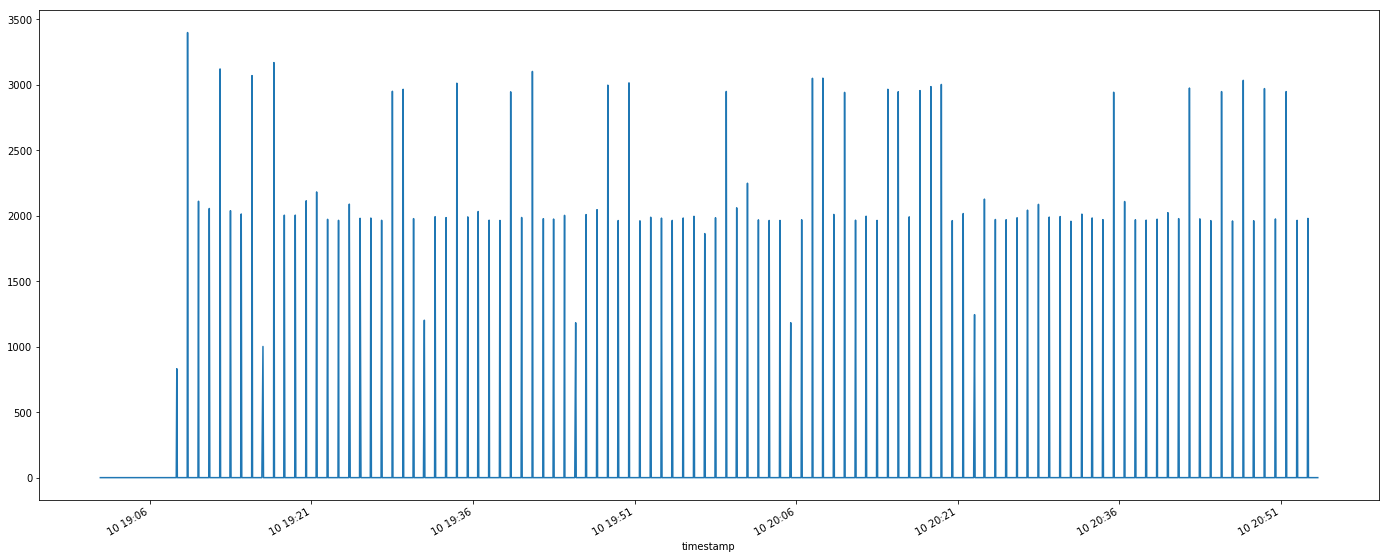

In [156]:
times['speed'].plot(figsize=(24,10))

What **is** concerning is that there was quite a delay before levski got started.  The test began at 19:02:44, but message processing didn't begin until almost 6 minutes later. From the data:

In [182]:
times.loc[[pd.to_datetime("2018-05-10 19:02:44"),pd.to_datetime("2018-05-10 19:08:30")]][['offset','log','lag']]

offset      log      lag
timestamp                                    
2018-05-10 19:02:44  264240   279240    15000
2018-05-10 19:08:30  266736  2664240  2397504

 Again, since this is all being re-written it's not a huge concern at this point, but we'll keep an eye on it.

## Cassandra write analysis

More interesting is how the data flowed into Cassandra.  By using the C* Writetime function, we can query each record to discover when it was written, and so compute Levski's processing rate.

This notebook queries perf01 directly at runtime.

In [46]:
cluster = Cluster(['174.32.2.182'])
session = cluster.connect()
session.set_keyspace('perf01dp_ptanalytics')

In [146]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)


session.row_factory = pandas_factory
session.default_fetch_size = None

query = "SELECT WRITETIME(vdouble) from vnf_data"
rslt = session.execute(query, timeout=None)
df = rslt._current_rows
df.index=df['writetime(vdouble)'].apply(lambda x: np.datetime64(x,"us"))

In [160]:
counts = df.resample('60S').count()
rows_per_second = counts["2018-05-10T19:08:00":].apply(lambda x:x/60)[:-1]
rows_per_second.plot(figsize=(24,10), title="Number of rows written per second")

A more analytical view shows that the performance is quite stable over the course of the trial, but quite slow.  At this rate it took about 7 hours to process 10 minutes worth of data for 1k entities.  20% of our current EBH target.

In [161]:
rows_per_second.describe()

writetime(vdouble)
count          401.000000
mean            99.709518
std              1.978881
min             90.533333
25%             98.516667
50%             99.133333
75%            100.233333
max            112.733333